In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import typhon
import utils
import datetime
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from netCDF4 import Dataset
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

# Configuration

In [2]:
platforms = ['BCO', 'RHB', 'M161', 'ATL'] # specify platform, e.g. BCO, RHB, M161 (Meteor), ATL (Atalante), MSM (Maria S Merian)
date = datetime.datetime(2020, 2, 1) # specify date
time_period = ['1400', '1800'] # specify time period (in UTC!)
branches = ['ascending'] # specify whether to use ascending or descending profiles (or both)
datapath = '/Users/u300740/Documents/PhD/EUREC4A/data/Radiosondes/NC' # path to directory containing sounding data (in netCDF format)
plot_dir = './plots' # directory to save plots
n_smooth = 10 # Window size for smoothing of profiles
profile_variables = ['altitude', 'pressure', 'temperature', 'humidity', 'mixingRatio',\
                     'windSpeed', 'windDirection', 'dewPoint'] 
attribute_variables = ['latitude', 'longitude', 'time_of_launch_HHmmss', 'date_YYYYMMDD', 'platform_name']
variables = profile_variables + attribute_variables

# Read data

In [3]:
date_str = date.strftime('%Y%m%d')
start_time = time_period[0]
end_time = time_period[1]
filenames = utils.get_filenames([date_str], start_time, end_time, platforms, branches, datapath)

profiles = []
for n, filename in enumerate(filenames):
    profiles.append(utils.profiles_from_netcdf(os.path.join(datapath, filename), variables))

# Calculate relevant quantities

In [4]:
# smooth profiles
profiles_smoothed = utils.smooth_profiles(profiles, profile_variables, n_smooth)
# calculate 
for profile in profiles_smoothed:
    profile['launch_time'] = datetime.datetime(
        year = int(profile['date_YYYYMMDD'][0:4]),
        month = int(profile['date_YYYYMMDD'][4:6]),
        day = int(profile['date_YYYYMMDD'][6:8]),
        hour = int(profile['time_of_launch_HHmmss'][0:2]),
        minute = int(profile['time_of_launch_HHmmss'][2:4])
    )
    profile['vmr'] = typhon.physics.relative_humidity2vmr(
        profile['humidity'] * 1e-2,
        profile['pressure'] * 1e2,
        profile['temperature'] + 273.15    
    )
    profile['specific_humidity'] = typhon.physics.vmr2specific_humidity(
        profile['vmr']
    )
    profile['potTemp'] = utils.calc_potential_temperature(
        profile['temperature'] + 273.15,
        profile['pressure'] * 1e2
    )
    profile['virtPotTemp'] = utils.calc_virtual_potential_temperature(
        profile['temperature'] + 273.15,
        profile['mixingRatio'] * 1e-3,
        profile['pressure'] * 1e2
    )

profiles_smoothed = sorted(profiles_smoothed, key=lambda profile: profile['launch_time'])
heights = np.arange(0, 20e3, 4)
profiles_interp = utils.interpolate_profiles(profiles_smoothed, ['pressure', 'temperature', 'humidity', 'mixingRatio', 'windSpeed', 'windDirection', 'dewPoint', 'specific_humidity', 'potTemp', 'virtPotTemp'], heights)

/opt/anaconda3/envs/field_campaign/lib/python3.7/site-packages/typhon/physics/thermodynamics.py:95: RuntimeWarning: invalid value encountered in less_equal
  if np.any(T <= 0):


# Platform comparison

## Platform positions

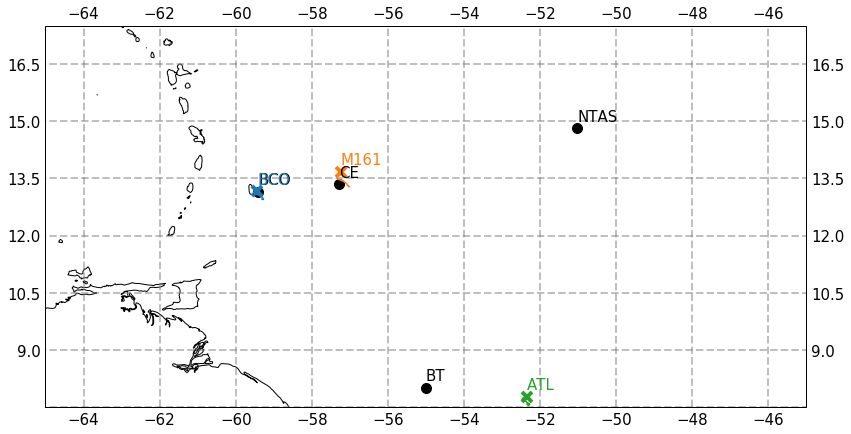

In [5]:
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(20, 7))

ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.set_extent([-65,-45,7.5,17.5], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(np.arange(-66, -42, 2))

# plot points for orientation (BCO, Circle East, NTAS, Boulevard)
ax.plot(-59.41, 13.15, 'o', transform=ccrs.PlateCarree(), label='BCO', markersize=10, color='k')
ax.text(-59.41, 13.35, 'BCO', transform=ccrs.PlateCarree(), color='k')
ax.plot(-57.28, 13.35, 'o', transform=ccrs.PlateCarree(), label='CE', markersize=10, color='k')
ax.text(-57.28, 13.55, 'CE', transform=ccrs.PlateCarree(), color='k')
ax.plot(-51.02, 14.82, 'o', transform=ccrs.PlateCarree(), label='NTAS', markersize=10, color='k')
ax.text(-51.02, 15.02, 'NTAS', transform=ccrs.PlateCarree(), color='k')
ax.plot(-55.0, 8.0, 'o', transform=ccrs.PlateCarree(), label='BT', markersize=10, color='k')
ax.text(-55.0, 8.2, 'BT', transform=ccrs.PlateCarree(), color='k')

# Plot Platform positions and radiosonde trajectories
for n, p in enumerate(profiles_smoothed):
    ax.plot(p['longitude'][0], p['latitude'][0], 'x',\
            transform=ccrs.PlateCarree(), markersize=10, markeredgewidth=4, lw=6, color=f'C{n}')
    ax.plot(p['longitude'], p['latitude'], color=f'C{n}')
    name = p['platform_name'][-4:-1]
    if name == '161':
        name = 'M161'
    ax.text(p['longitude'][0], p['latitude'][0] + 0.2, f'{name}', transform=ccrs.PlateCarree(), color=f'C{n}')

# Save figure
plt.savefig(os.path.join(plot_dir, f'map_{date_str}.pdf'))

## Platform soundings

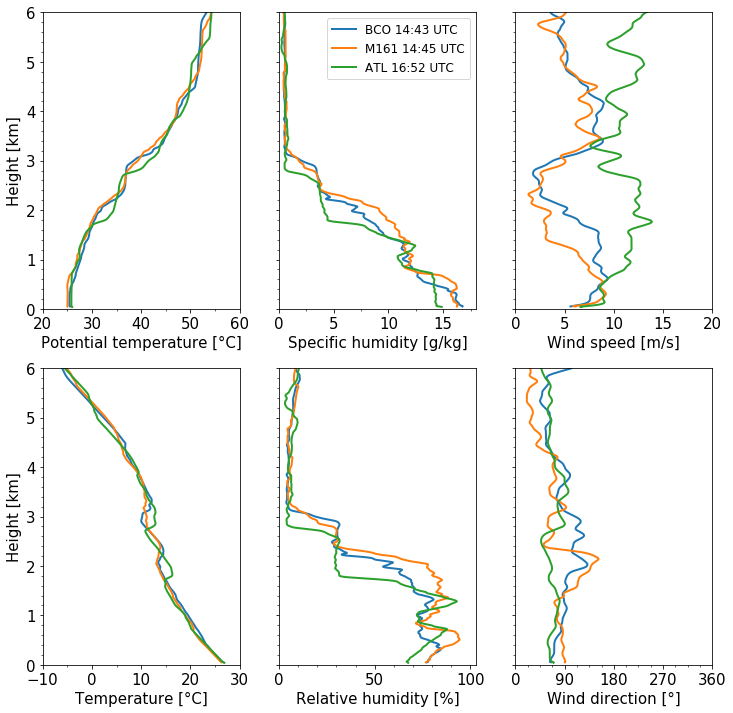

In [6]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(2, 3, figsize=(12, 12), sharey=True)
ax = ax.ravel()
for n, profile in enumerate(profiles_smoothed):
    hh = profile['time_of_launch_HHmmss'][0:2]
    mm = profile['time_of_launch_HHmmss'][2:4]
    launch_time = f'{hh}:{mm} UTC'
    platform_name = profile['platform_name'][-4:-1]
    if platform_name == '161':
        platform_name = 'M161'
    ax[0].plot(profile['potTemp'] - 273.15, profile['altitude'] * 1e-3,\
               color=f'C{n}', lw=2, label=f'{platform_name} {launch_time}')
    ax[1].plot(profile['specific_humidity'] * 1e3, profile['altitude'] * 1e-3,\
               color=f'C{n}', lw=2, label=f'{platform_name} {launch_time}')
    ax[2].plot(profile['windSpeed'], profile['altitude'] * 1e-3, color=f'C{n}', lw=2)
    ax[3].plot(profile['temperature'], profile['altitude'] * 1e-3, color=f'C{n}', lw=2)
    ax[4].plot(profile['humidity'], profile['altitude'] * 1e-3, color=f'C{n}', lw=2)
    ax[5].plot(profile['windDirection'], profile['altitude'] * 1e-3, color=f'C{n}', lw=2)
    ax[0].set_ylim(0, 6)  

ax[0].set_ylabel('Height [km]')
ax[0].set_xlim(-10, 30)
ax[0].set_xlabel('Potential temperature [°C]')
ax[0].set_xlim(20, 60)
ax[0].xaxis.set_minor_locator(MultipleLocator(5))

ax[1].legend(fontsize=12)
ax[1].set_xlabel('Specific humidity [g/kg]')
ax[1].set_xlim(0, 18)
ax[1].xaxis.set_minor_locator(MultipleLocator(2.5))

ax[2].set_xlabel('Wind speed [m/s]')
ax[2].set_xlim(0, 20)

ax[3].set_ylabel('Height [km]')
ax[3].set_xlabel('Temperature [°C]')
ax[3].xaxis.set_major_locator(MultipleLocator(10))
ax[3].xaxis.set_minor_locator(MultipleLocator(5))
ax[3].yaxis.set_minor_locator(MultipleLocator(0.25))
ax[3].set_xlim(-10, 30)

ax[4].set_xlabel('Relative humidity [%]')
ax[4].set_xlim(0, 103)
ax[4].xaxis.set_minor_locator(MultipleLocator(10))

ax[5].set_xlim(0, 360)
ax[5].xaxis.set_major_locator(MultipleLocator(90))
ax[5].xaxis.set_minor_locator(MultipleLocator(30))
ax[5].set_xlabel('Wind direction [°]')

plt.minorticks_on()

# Save figure
plt.savefig(os.path.join(plot_dir, f'soundings_platforms_{date_str}.pdf'))